In [11]:
import json, os, torch, cv2, numpy as np, albumentations as A
from PIL import Image; from matplotlib import pyplot as plt
from glob import glob; from PIL import ImageFile
from torch.utils.data import random_split, Dataset, DataLoader
from albumentations.pytorch import ToTensorV2

In [13]:
import shutil
def data_yuklab_olish(saqlash_uchun_papka, data_nomi = "lentils"):

    data_nomlari = ["salaries", "exams", "college", "cars_detection", "car_brands", "mall", "customers", "humanitarian",
                    "apple_disease", "insects", "cars", "crop", "dog_breeds", "rice_leaf_disease", "lentils", "brain", "flood",
                    "fruits", "aeroscapes", "cardiac", "vehicles", "cloud", "skin_lesion", "comments", "3d_data", "50_car_brands"]

    assert data_nomi in data_nomlari, f"Mavjud bo'lgan dataset {data_nomlari} dan birini kiriting!"

    if data_nomi == "rice_leaf_disease": url = "kaggle datasets download -d killa92/rice-leaf-disease-classification-dataset"
    elif data_nomi == "lentils": url = "kaggle datasets download -d killa92/lentils-classification-dataset"
    elif data_nomi == "aeroscapes": url = "kaggle datasets download -d killa92/aerospaces-semantic-segmentation-dataset"
    elif data_nomi == "cardiac": url = "kaggle datasets download -d killa92/cardiac-semantic-segmentation-dataset"
    elif data_nomi == "brain": url = "kaggle datasets download -d killa92/brain-ct-tumor-classification-dataset"
    elif data_nomi == "fruits": url = "kaggle datasets download -d killa92/fruits-classification-dataset"
    elif data_nomi == "apple_disease": url = "kaggle datasets download -d killa92/apple-disease-dataset"
    elif data_nomi == "vehicles": url = "kaggle datasets download -d killa92/vehicle-detection-dataset"
    elif data_nomi == "cloud": url = "kaggle datasets download -d killa92/cloud-quality-images-classification-dataset"
    elif data_nomi == "insects": url = "kaggle datasets download -d killa92/arthropodia-semantic-segmentation-dataset"
    elif data_nomi == "cars_detection": url = "kaggle datasets download -d killa92/car-detect-dataset"
    elif data_nomi == "skin_lesion": url = "kaggle datasets download -d killa92/skin-lesion-image-ham-classification"
    elif data_nomi == "crop": url = "kaggle datasets download -d killa92/crop-disease-image-classification-dataset"
    elif data_nomi == "comments": url = "kaggle datasets download -d killa92/comments-nlp-sentiment-analysis-dataset"
    elif data_nomi == "car_brands": url = "kaggle datasets download mohamedaziz15/cars-brands-in-egypt"
    elif data_nomi == "3d_data": url = "kaggle datasets download glxslzt/3cla-adni"
    elif data_nomi == "50_car_brands": url = "kaggle datasets download yamaerenay/100-images-of-top-50-car-brands"
    elif data_nomi == "dog_breeds": url = "kaggle datasets download yxshee/dogs-dataset"
    elif data_nomi == "flood": url = "kaggle datasets download killa92/flood-image-segmentation"

    # Dataset yuklab olinganligini tekshirish
    if os.path.isfile(f"{saqlash_uchun_papka}/{data_nomi}.csv") or os.path.isdir(f"{saqlash_uchun_papka}/{data_nomi}"): print(f"Dataset yuklab olingan. {saqlash_uchun_papka}/{data_nomi} papkasini ni tekshiring."); pass

    # Agar dataset yuklab olinmagan bo'lsa:
    else:
        # dataset nomini aniqlash
        ds_nomi = url.split("/")[-1]
        # data saqlanadigan yo'lakni belgilash
        full_path = f"{saqlash_uchun_papka}/{ds_nomi}"
        print(f"{data_nomi} dataset yuklanmoqda...")
        # Datasetni belgilangan yo'lakka yuklab olish
        os.system(f"{url} -p {full_path}")
        # Arxivdan chiqarib olish
        shutil.unpack_archive(f"{full_path}/{ds_nomi}.zip", f"{saqlash_uchun_papka}/{ds_nomi}")
        # Original arxiv faylni o'chirib tashlash
        os.remove(f"{full_path}/{ds_nomi}.zip")
        # Yuklab olingan datasetning nomini o'zgartirish
        os.rename(f"{saqlash_uchun_papka}/{ds_nomi}", f"{saqlash_uchun_papka}/{data_nomi}")
        print(f"Tanlangan dataset {saqlash_uchun_papka}/{data_nomi} papkasiga yuklab olindi!")

# Funktsiyadan foydalanish misoli
data_yuklab_olish(saqlash_uchun_papka = "datasets", data_nomi = "insects")

Dataset yuklab olingan. datasets/insects papkasini ni tekshiring.


In [17]:
ImageFile.LOAD_TRUNCATED_IMAGES = True
data_path = "datasets/insects/arthropodia"

class CustomDataset(Dataset):
    def __init__(self, data_path, transformations = None):
        super().__init__()
        
        self.img_paths   = sorted(glob(f"{data_path}/images/*.jpg"))
        self.gt_paths = sorted(glob(f"{data_path}/labels/*.png"))
        self.label_paths = [name.replace("images", "labels").replace(".jpg", ".png") for name in self.img_paths if os.path.isfile(name.replace("images", "labels").replace(".jpg", ".png"))]
        self.n_cls = 2
        self.transformations = transformations
        assert len(self.img_paths) == len(self.label_paths)

    def __len__(self): return len(self.img_paths)

    def __getitem__(self, idx):
        img, label  = self.get_img_label(self.img_paths[idx], self.label_paths[idx])
        if self.transformations: img, label = self.apply_transformations(img, label)
        return img, (label/255).int()

    def get_img_label(self, img_path, label_path):
        return self.read_img(img_path, label_path)

    def read_img(self, img_path, label_path): return np.array(Image.open(img_path).convert("RGB")), np.array(Image.open(label_path).convert("L"))

    def apply_transformations(self, img, label): transformed = self.transformations(image = img, mask = label); return transformed['image'], transformed['mask']


def get_dls(data_path, transformations, bs, split = [0.9, 0.05]):
    ds = CustomDataset(data_path = data_path, transformations = transformations)
    n_cls = ds.n_cls
    
    total_len = len(ds)
    tr_len = int(total_len * split[0])
    vl_len = int(total_len * split[1])
    ts_len = total_len - (tr_len + vl_len)

    tr_ds, vl_ds, ts_ds = torch.utils.data.random_split(ds, [tr_len, vl_len, ts_len])
    print(f"train ds da {len(tr_ds)} ta rasm bor.")
    print(f"Validation ds da {len(vl_ds)} ta rasm bor.")
    print(f"test ds da {len(ts_ds)} ta rasm bor.")

    tr_dl = DataLoader(tr_ds, batch_size = bs, shuffle = True, num_workers = 0)
    vl_dl = DataLoader(vl_ds, batch_size = bs, shuffle = False, num_workers = 0)
    ts_dl = DataLoader(ts_ds, batch_size = 1, shuffle = False, num_workers = 0)
    return tr_dl, vl_dl, ts_dl, n_cls

mean, std, img_h, img_w = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 256, 256
transforming = A.Compose( [ A.Resize(img_h, img_w), A.augmentations.transforms.Normalize(mean=mean, std=std), ToTensorV2(transpose_mask = True)], is_check_shapes = False )
tr_dl, vl_dl, ts_dl, n_cls = get_dls(data_path = data_path, transformations = transforming, bs = 32)


train ds da 4454 ta rasm bor.
Validation ds da 247 ta rasm bor.
test ds da 248 ta rasm bor.


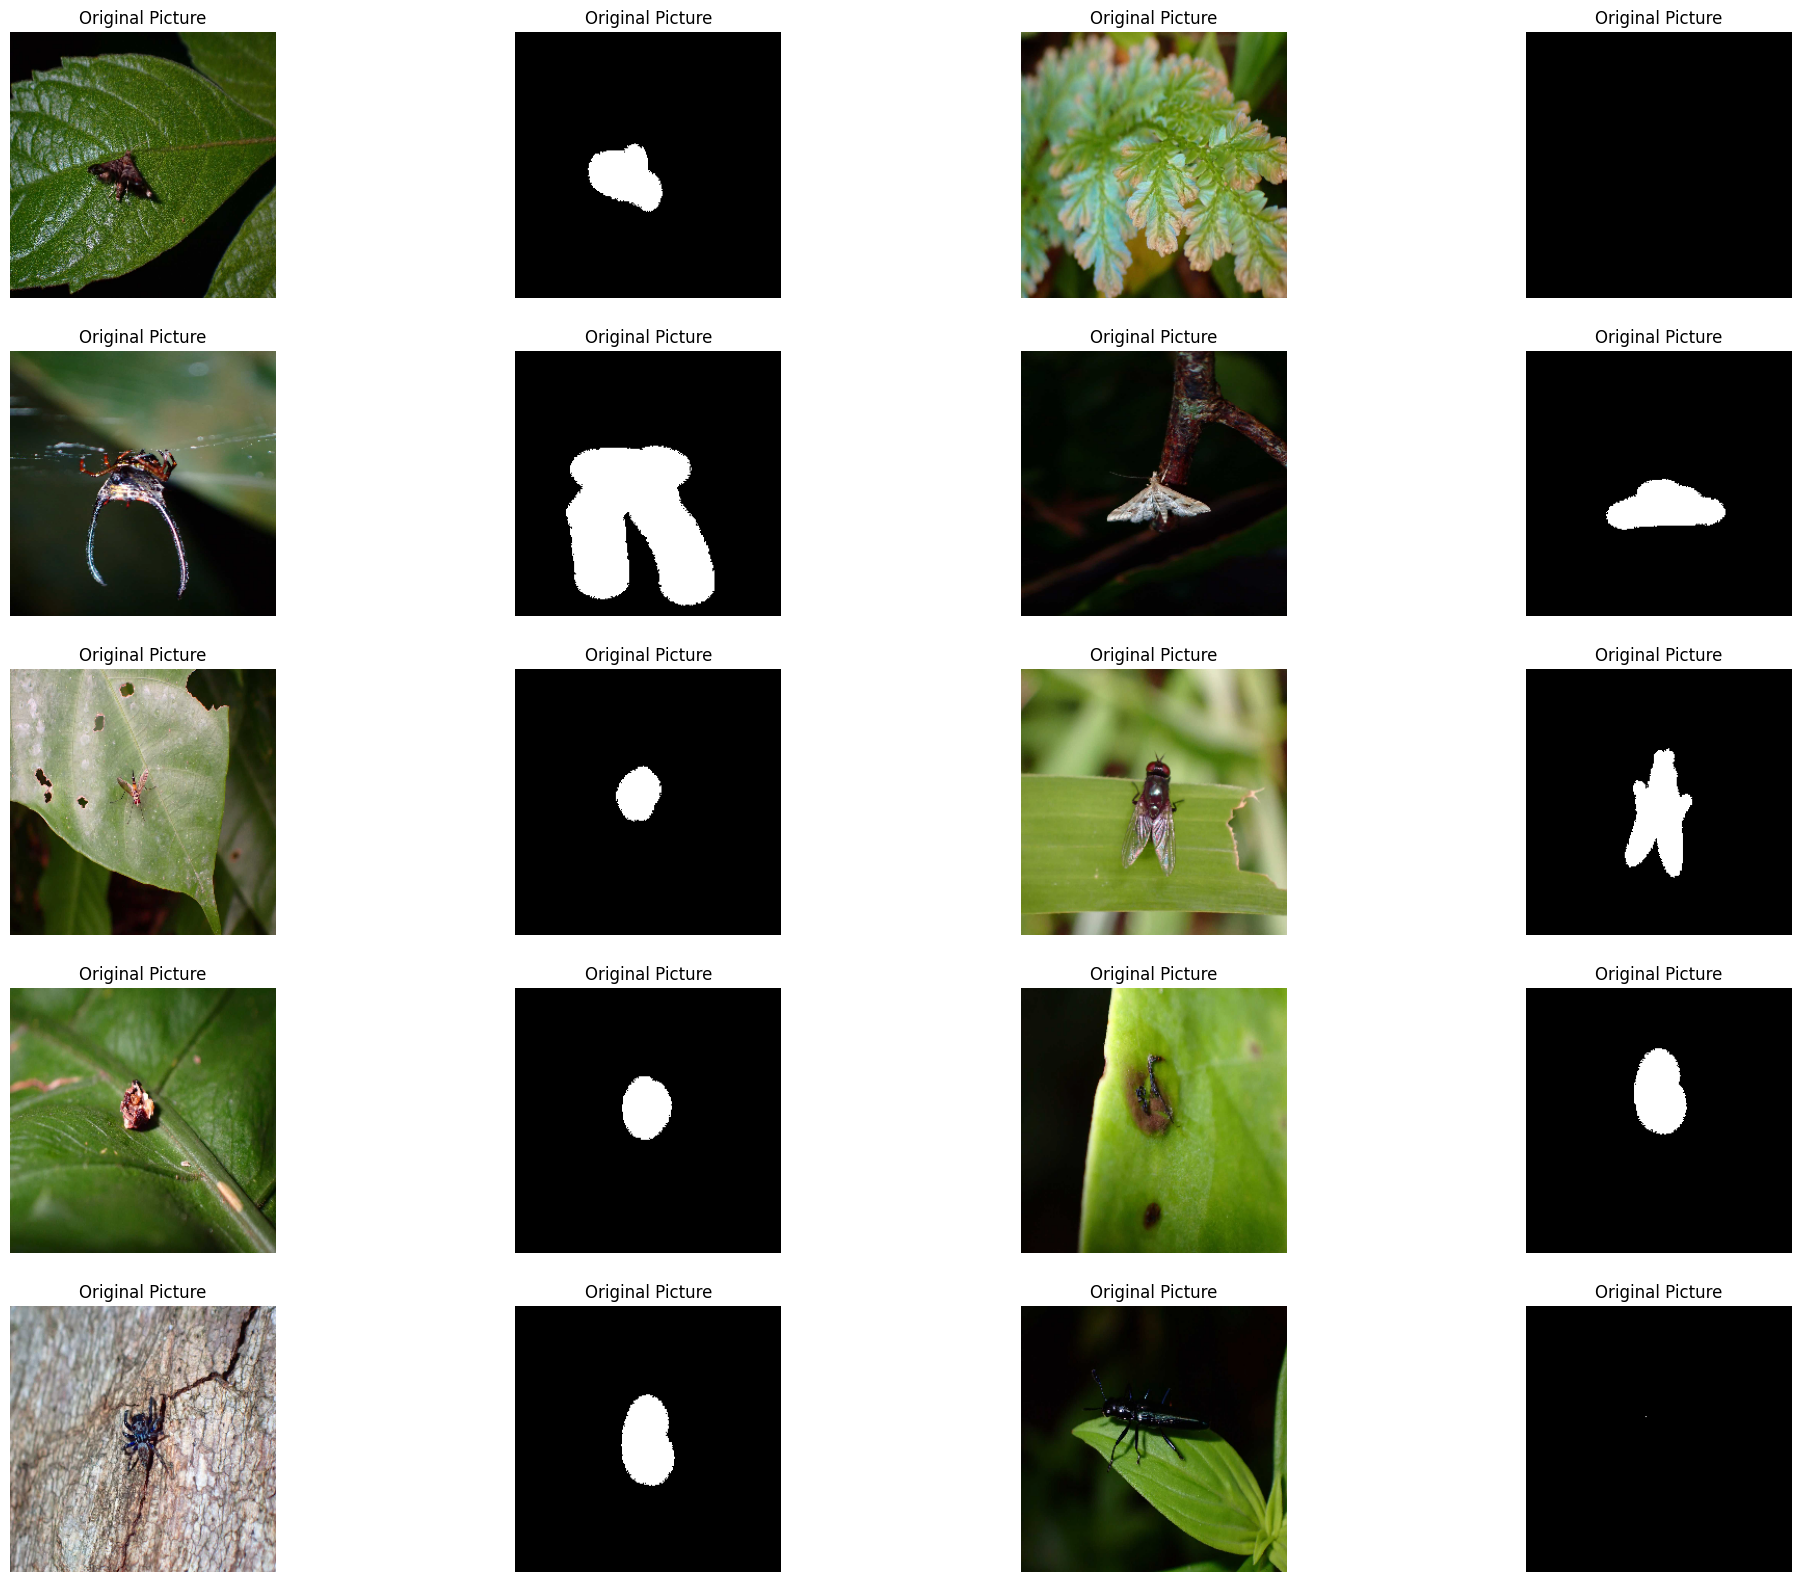

In [19]:
import random
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms as tfs

class DataVisualization:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        self.inv_transform = self.get_inverse_transform()

    def get_inverse_transform(self):
        return tfs.Compose([
            tfs.Normalize(mean=[0., 0., 0.], std=[1 / s for s in self.std]),
            tfs.Normalize(mean=[-m for m in self.mean], std=[1., 1., 1.])
        ])

    def tensor_2_numpy(self, tensor):

        is_rgb = len(tensor) == 3
        if is_rgb:
            tensor = self.inv_transform(tensor)
            np_array = (tensor * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)
        else: 
            np_array = (tensor * 255).detach().cpu().numpy().astype(np.uint8)
        
        return np_array


    def plot(self, rows, cols, count, img, is_gt = False, title = "Original Picture"):
        
        plt.subplot(rows, cols, count)
        plt.imshow(self.tensor_2_numpy(img.squeeze(0).float()) if is_gt else self.tensor_2_numpy(img.squeeze(0)), cmap = "gray")
        plt.axis("off")
        plt.title(title)
        return count + 1

    def visualizer(self, dataset, num_images):
        plt.figure(figsize = (25, 20))
        rows = num_images // 4
        cols = num_images // rows
        count = 1

        indices = [random.randint(0, len(dataset)-1) for _ in range(num_images)]
        for index in indices:
            if count > num_images:
                break
            pic, label = dataset[index]
            count = self.plot(rows, cols, count, pic)
            count = self.plot(rows, cols, count, label, is_gt = True)

show = DataVisualization(mean = mean, std = std)
show.visualizer(tr_dl.dataset, 20)
        
        

In [23]:
import segmentation_models_pytorch as smp, time
from torch.nn import functional as F
from tqdm import tqdm

model = smp.DeepLabV3Plus(classes = n_cls)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 3e-4)

class Metrics:
    def __init__(self, pred, label, loss_fn, eps = 1e-10, n_cls = 2):
        self.pred = torch.argmax(pred, dim = 1)
        self.label = label.squeeze(1)
        self.pred_ = pred
        self.loss_fn = loss_fn
        self.eps = eps
        self.n_cls = n_cls

    def to_contiguous(self, inp): return inp.contiguous().view(-1)

    def PixelAcc(self):
        with torch.no_grad():
            
            match = torch.eq(self.pred, self.label).int()
            
        return float(match.sum())/ float(match.numel())

    def meanIoU(self):
        with torch.no_grad():
            
            pred = self.to_contiguous(self.pred)
            label = self.to_contiguous(self.label)
            iou_per_class = []

            for c in range(n_cls):
                match_pred = pred == c
                match_label = label == c

                if match_label.long().sum().int() == 0:
                    iou_per_class.append(np.nan)
                else:
                    intersect = torch.logical_and(match_pred, match_label).sum().float().item()
                    union = torch.logical_or(match_pred, match_label).sum().float().item()
                    iou = intersect / (union + self.eps)
                    iou_per_class.append(iou)

            return np.nanmean(iou_per_class)
    def loss(self):
        return self.loss_fn(self.pred_, self.label.long())
        
def timer(start_time = None): return time.time() if start_time == None else time.time() - start_time
                        

C:\Users\Nodir\anaconda3\envs\segmentation\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
class Trainer:
    def __init__(self, model, tr_dl, vl_dl, loss_fn, optimizer, device, n_cls, folder_2_save = "segmentation Best models"):
        self.model = model
        self.tr_dl = tr_dl
        self.vl_dl = vl_dl
        self.device = device
        self.n_cls = n_cls
        self.folder_2_save = folder_2_save
        self.loss_fn = loss_fn
        self.optimizer = optimizer

        os.makedirs(self.folder_2_save, exist_ok = True)

    def run(self, epochs, path_prefix):

        self.model.to(self.device)
        tr_loss, tr_pa, tr_iou = [], [], []
        vl_loss, vl_pa, vl_iou = [], [], []
        best_loss, not_improved = np.inf, 0

        print(f"Training process is beginning...")
        for epoch in range(1, epochs+1):
            print(f"{epoch}/{epochs}")
            
            # Train process
            self.model.train()
            tr_metrics = self.process_epoch(self.tr_dl, is_training = True)

            # Validation 
            self.model.eval()
            with torch.no_grad():
                vl_metrics = self.process_epoch(self.vl_dl, is_training = False)

            tr_loss.append(tr_metrics["loss"])
            tr_pa.append(tr_metrics["pa"])
            tr_iou.append(tr_metrics["iou"])
            vl_loss.append(vl_metrics["loss"])
            vl_pa.append(vl_metrics["pa"])
            vl_iou.append(vl_metrics["iou"])

            print(f"Train Loss: {tr_metrics['loss']:.3f} | Train PA: {tr_metrics['pa']:.3f} | Train IoU: {tr_metrics['iou']:.3f}")
            print(f"Valid loss {vl_metrics['loss']:.3f} | Valid PA {vl_metrics['pa']:.3f} | Valid IOU {vl_metrics['iou']:.3f}")
            
            if best_loss > vl_metrics["loss"]:
                best_loss = vl_metrics["loss"]
                not_improved = 0
                torch.save(self.model, f"{self.folder_2_save}/{path_prefix}_best_flood_model.pth")
            else:
                not_improved += 1
                if not_improved == 5:
                    print(f"Early stopping triggered. Best loss is - {best_loss}")
                    break

        return {
            "tr_loss" : tr_loss, "tr_pa" : tr_pa, "tr_iou" : tr_iou,
            "vl_loss" : vl_loss, "vl_pa" : vl_pa, "vl_iou" : vl_iou,
            
        }

    def process_epoch(self, dataloader, is_training):
        if is_training:
            phase = "Train"
        else:
            phase = "Validation"
        total_loss, total_pa, total_iou = 0, 0, 0
        for img, label in tqdm(dataloader, desc = f"{phase} process..."):
            img = img.to(self.device)
            label = label.to(self.device)
            if is_training:
                pred = self.model(img)
                metrics = Metrics(pred, label, self.loss_fn, n_cls = self.n_cls)
                loss = metrics.loss()

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            else: # Validation
                with torch.no_grad():
                    pred = self.model(img)
                    metrics = Metrics(pred, label, self.loss_fn, n_cls = self.n_cls)
                    loss = metrics.loss()

            total_loss += loss.item()
            total_pa   += metrics.PixelAcc()
            total_iou  += metrics.meanIoU()
        num_batches = len(dataloader)
        return {
            "loss" : total_loss / num_batches,
            "pa"   : total_pa / num_batches,
            "iou"  : total_iou / num_batches,
        }

device = "cuda" if torch.cuda.is_available() else "cpu"

trainer = Trainer(model = model, tr_dl = tr_dl, vl_dl = vl_dl, loss_fn = loss_fn, optimizer = optimizer, device = device, n_cls = n_cls)
final = trainer.run(epochs = 30, path_prefix = "flood")
                
            

Training process is beginning...
1/30


Validation process...: 100%|█████████████████████████████████████████████████████████████| 8/8 [00:31<00:00,  3.94s/it]


Train Loss: 0.154 | Train PA: 0.952 | Train IoU: 0.760
Valid loss 0.114 | Valid PA 0.957 | Valid IOU 0.801
2/30


Validation process...: 100%|█████████████████████████████████████████████████████████████| 8/8 [00:31<00:00,  3.97s/it]


Train Loss: 0.076 | Train PA: 0.971 | Train IoU: 0.836
Valid loss 0.085 | Valid PA 0.966 | Valid IOU 0.832
3/30


Validation process...: 100%|█████████████████████████████████████████████████████████████| 8/8 [00:34<00:00,  4.28s/it]


Train Loss: 0.061 | Train PA: 0.976 | Train IoU: 0.861
Valid loss 0.081 | Valid PA 0.967 | Valid IOU 0.834
4/30


Validation process...: 100%|█████████████████████████████████████████████████████████████| 8/8 [00:25<00:00,  3.24s/it]


Train Loss: 0.055 | Train PA: 0.978 | Train IoU: 0.870
Valid loss 0.109 | Valid PA 0.954 | Valid IOU 0.800
5/30


Validation process...: 100%|█████████████████████████████████████████████████████████████| 8/8 [00:25<00:00,  3.17s/it]


Train Loss: 0.056 | Train PA: 0.977 | Train IoU: 0.867
Valid loss 0.075 | Valid PA 0.969 | Valid IOU 0.845
6/30


Validation process...: 100%|█████████████████████████████████████████████████████████████| 8/8 [00:25<00:00,  3.16s/it]


Train Loss: 0.048 | Train PA: 0.980 | Train IoU: 0.884
Valid loss 0.080 | Valid PA 0.969 | Valid IOU 0.847
7/30


Validation process...: 100%|█████████████████████████████████████████████████████████████| 8/8 [00:24<00:00,  3.12s/it]


Train Loss: 0.042 | Train PA: 0.982 | Train IoU: 0.896
Valid loss 0.073 | Valid PA 0.972 | Valid IOU 0.855
8/30


Validation process...: 100%|█████████████████████████████████████████████████████████████| 8/8 [00:24<00:00,  3.08s/it]


Train Loss: 0.037 | Train PA: 0.984 | Train IoU: 0.907
Valid loss 0.078 | Valid PA 0.971 | Valid IOU 0.849
9/30


Validation process...: 100%|█████████████████████████████████████████████████████████████| 8/8 [00:24<00:00,  3.03s/it]


Train Loss: 0.035 | Train PA: 0.985 | Train IoU: 0.913
Valid loss 0.076 | Valid PA 0.973 | Valid IOU 0.859
10/30


Validation process...: 100%|█████████████████████████████████████████████████████████████| 8/8 [00:24<00:00,  3.09s/it]


Train Loss: 0.032 | Train PA: 0.986 | Train IoU: 0.918
Valid loss 0.082 | Valid PA 0.972 | Valid IOU 0.854
11/30


Validation process...: 100%|█████████████████████████████████████████████████████████████| 8/8 [00:24<00:00,  3.11s/it]


Train Loss: 0.031 | Train PA: 0.987 | Train IoU: 0.920
Valid loss 0.076 | Valid PA 0.973 | Valid IOU 0.864
12/30


Validation process...: 100%|█████████████████████████████████████████████████████████████| 8/8 [00:25<00:00,  3.24s/it]

Train Loss: 0.028 | Train PA: 0.988 | Train IoU: 0.929
Valid loss 0.084 | Valid PA 0.972 | Valid IOU 0.856
Early stopping triggered. Best loss is - 0.07304787822067738


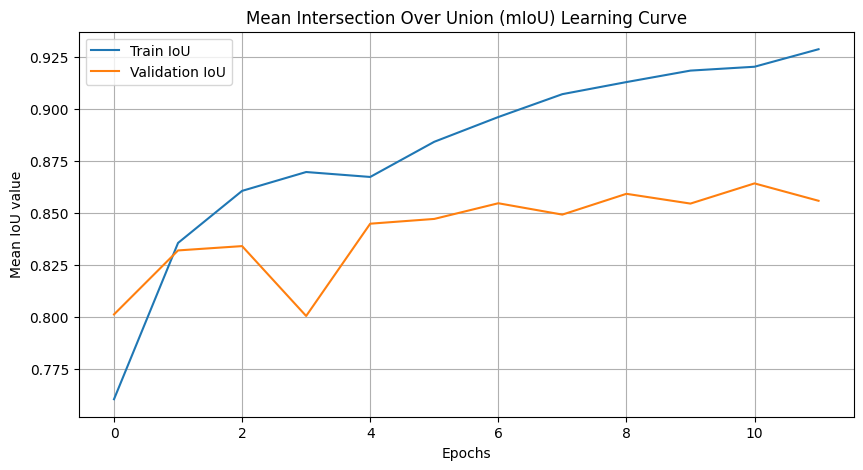

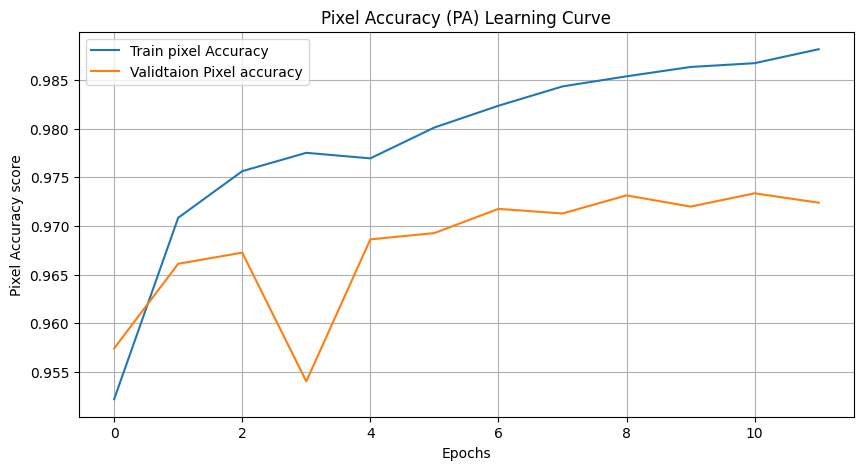

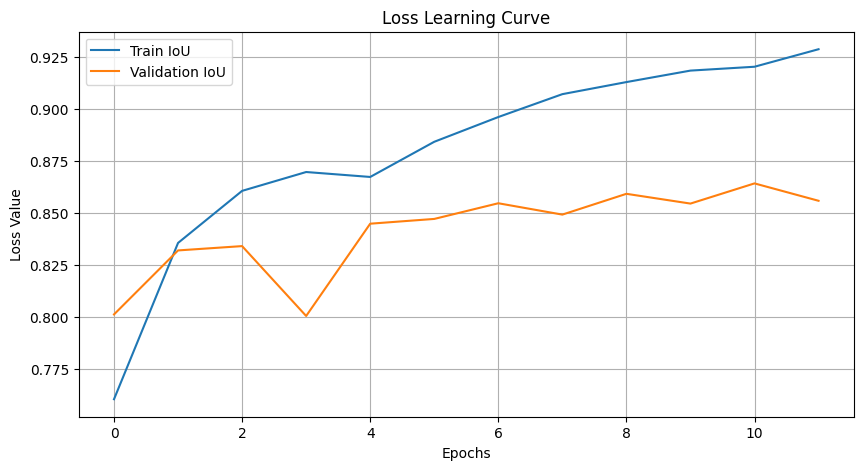

In [27]:
class Plot:
    def __init__(self, final):
        self.final = final
        self.plot_all()

    def plot_metrics(self, metric1, metric2, label1, label2, title, ylabel):
        plt.figure(figsize = (10,5))
        plt.plot(self.final[metric1], label = label1)
        plt.plot(self.final[metric2], label = label2)
        plt.title(title)
        plt.ylabel(ylabel)
        plt.xlabel("Epochs")
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_all(self):
        self.plot_metrics(
            metric1 = "tr_iou", metric2 = "vl_iou",
            label1  = "Train IoU", label2 = "Validation IoU",
            ylabel  = "Mean IoU value", 
            title   = "Mean Intersection Over Union (mIoU) Learning Curve"
        )

        self.plot_metrics(
            metric1 = "tr_pa", metric2 = "vl_pa",
            label1  = "Train pixel Accuracy", label2 = "Validtaion Pixel accuracy",
            ylabel  = "Pixel Accuracy score",
            title   = "Pixel Accuracy (PA) Learning Curve"
        )

        self.plot_metrics(
            metric1 = "tr_iou", metric2 = "vl_iou",
            label1  = "Train IoU", label2 = "Validation IoU",
            title   ="Loss Learning Curve",
            ylabel  ="Loss Value"
        )

Plot(final)

C:\Users\Nodir\AppData\Local\Temp\ipykernel_14168\2263052190.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model = torch.load(model_path, map_location = device)


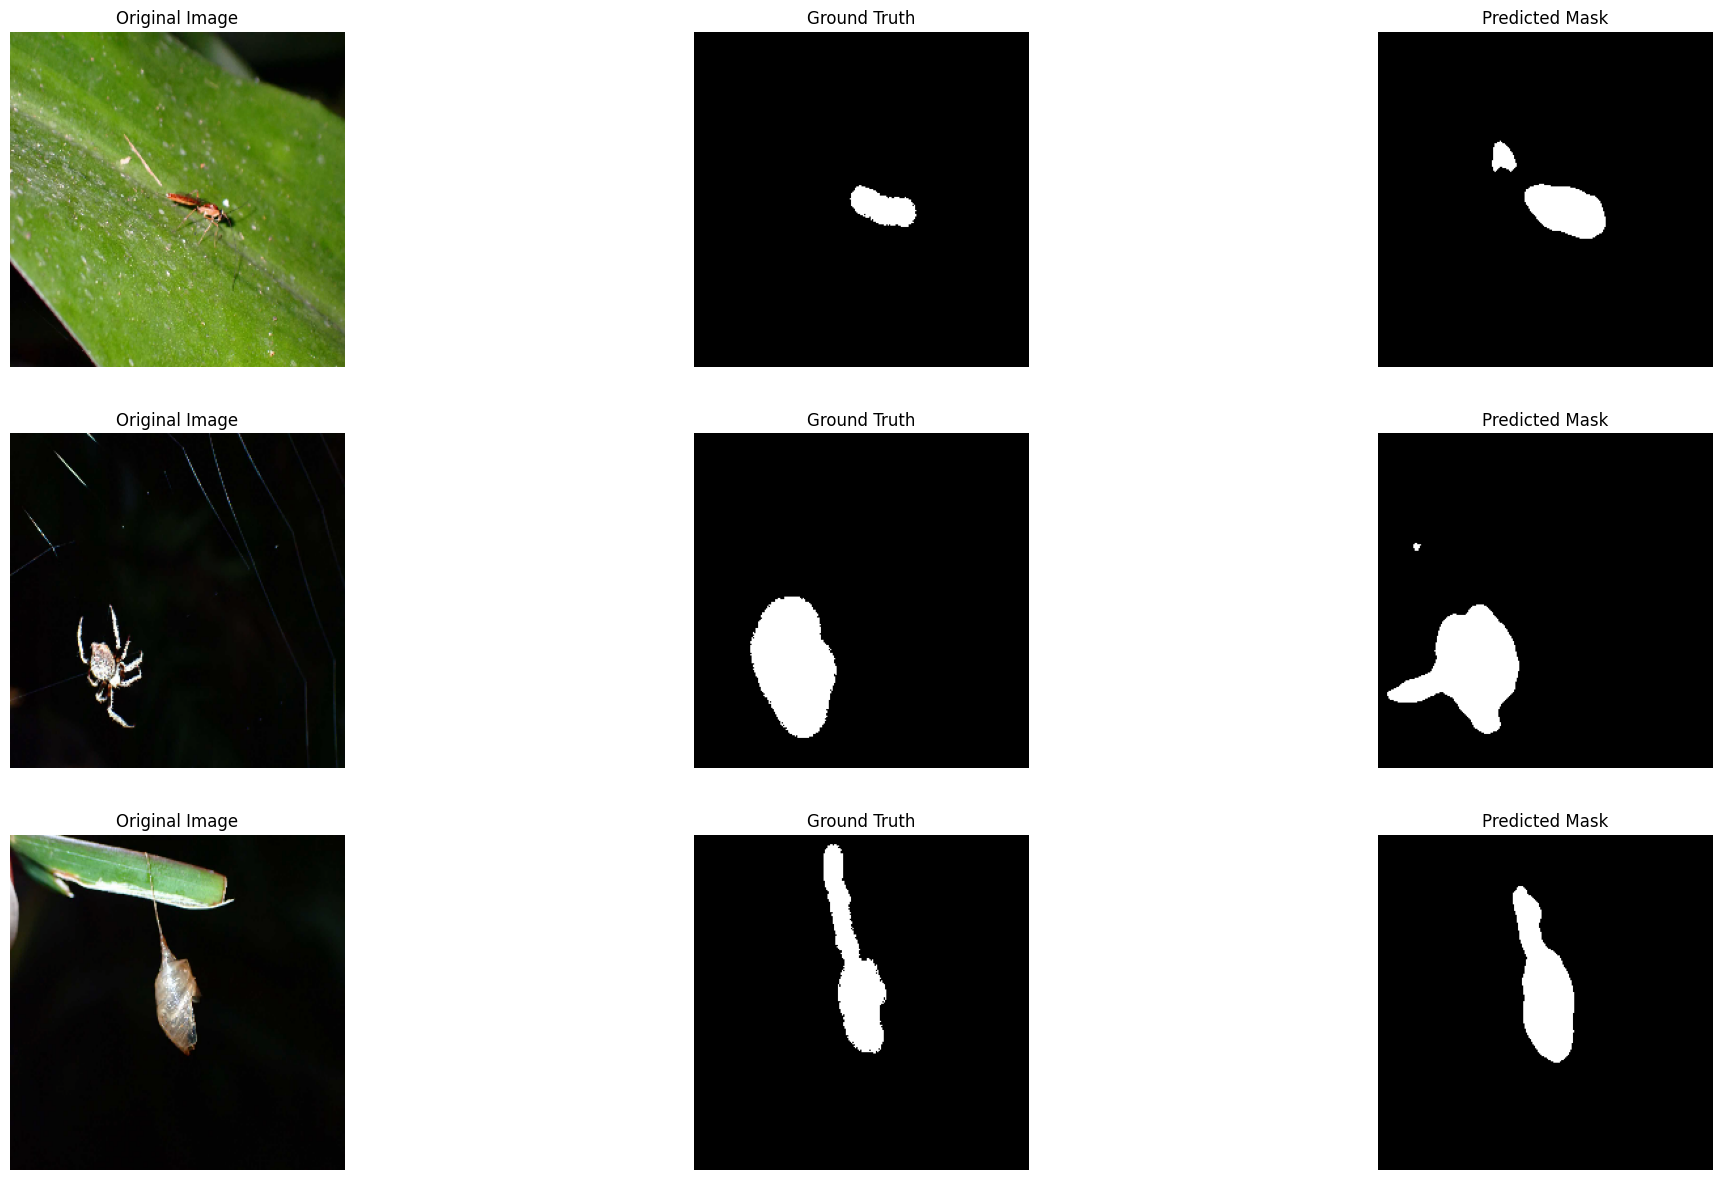

In [29]:
from torchvision import transforms as tfs
class Inference:
    def __init__(self,model_path, device):
        self.device = device
        self.model = torch.load(model_path, map_location = device)
        self.model.to(device)
        self.model.eval()

    def tn_2_np(self, tensor):
        
        invTrans = tfs.Compose([
            tfs.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]),
            tfs.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.])
        ])
        rgb = True if len(tensor.shape) == 3 else False
        return (invTrans(tensor) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8) if rgb else (tensor * 255).detach().cpu().numpy().astype(np.uint8)

    def plot(self, rows, cols, count, img, label=None, title="Original Image"):
        
        plt.subplot(rows, cols, count)
        plt.imshow(self.tn_2_np(img.squeeze(0).float()), cmap = "gray") if label else plt.imshow(self.tn_2_np(img.squeeze(0)), cmap = "gray")
        plt.axis("off")
        plt.title(title)
        return count + 1

    def run(self, ts_dl, num_imgs = 15, cols = 3):
        
        rows = num_imgs // cols
        count = 1
        imgs, labels, preds = [], [], []

        for idx, data in enumerate(ts_dl):
            img, label = data
            
            with torch.no_grad():
                pred = torch.argmax(self.model(img.to(self.device)), dim = 1)

            imgs.append(img)
            labels.append(label)
            preds.append(pred)

        plt.figure(figsize=(25, 20))
        for idx, (img, label, pred) in enumerate(zip(imgs, labels, preds)):
            if idx == cols:
                break

            # Plot original image
            count = self.plot(rows, cols, count, img)

            # Plot ground truth
            count = self.plot(rows, cols, count, img=label.squeeze(0), label=True, title="Ground Truth")

            # Plot predicted mask
            count = self.plot(rows, cols, count, img=pred, title="Predicted Mask")

model_path = "segmentation Best models/insect_best_flood_model.pth"
inference_runner = Inference(model_path=model_path, device=device)
inference_runner.run(ts_dl, num_imgs=12)